DSCI 100 004

Laura Flannigan, Kaitlyn Harvie, Hannah Morstead, & Tony Tang 

<p style = "font-size:22pt"> Predicting Heart Disease from Multiple Demographic and Risk Factors Variables </p>

 **<p style = "font-size:18pt; font-style:bold"> Introduction </p>**

According to the World Health Organization, the leading cause of death worldwide is cardiovascular diseases (2021). However, heart disorders can be preventable, as research has revealed various risk factors in the development of heart disease. Yusuf et al. (2001) suggested that high blood pressure and increased LDL cholesterol levels show causal links to cardiovascular disease. Additionally, the presence of chest pain has been found to be associated with increased risk of long-term cardiovascular disease (Robson et al., 2015), as well as ECG abnormalities which are suggestive of an increased risk of heart disease (Whincup, 1995). Other variables, such as gender and age, contribute to risk factors (Maas & Appelman, 2010).

Using the processed Cleveland Heart Disease dataset from the Cleveland Clinic Foundation (Detrano, 1989), obtained from the UCI Machine Learning Repository, we will determine how accurately a K-Nearest Neighbors classification model correctly predicts the presence of a heart disease diagnosis for a new, unknown observation. The data set contains 303 observations collected from individuals undergoing angiography. The classification algorithm will use the following predictor varibles, selected from the original data set: age, sex, chest pain type, resting blood pressure, blood cholesterol levels, resting ECG results, and presence of exercise-indudced angina.

**<p style = "font-size:18pt; font-style:bold"> Preliminary Exploratory Data Analysis </p>**

To begin, the seed is set to ensure the model is reproducible. Required libaries are loaded and the Cleveland Heart Disease data set is read in — ensuring approporate and readable column names. The response variable (diagnosis) is mutated as a factor variable type to allow for future classification of unknown observations. 

In [2]:
# Set the seed for the notebook, load required libraries, and set options.
set.seed(1248)
library(tidyverse)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 15, repr.plot.height = 4)

# Download and read the original dataset, mutating columns with factor variables to the correct type.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, "data/processed_cleveland.csv")
cleveland_data <- read_csv("data/processed_cleveland.csv", col_names = c("age", "sex", "cp_type", "resting_bp",
                           "cholesterol", "fasting_bs", "ECG_results", "max_pulse", "exercise_ang", "ST_depress",
                           "slope_ST", "fluoroscopy", "thal", "diagnosis"), na = "?") %>%
    mutate(diagnosis = as_factor(diagnosis))
cleveland_data

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

age,sex,cp_type,resting_bp,cholesterol,fasting_bs,ECG_results,max_pulse,exercise_ang,ST_depress,slope_ST,fluoroscopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,0


Table 1: Table of all variables in the Cleveland Heart Disease Dataset. Column names are nemaed and the diagnosis variable was change to a factor variable.

The outcomes 1 through 4 of the diagnosis variable all indicate the presence of heart disease, and the increasing numberical values signify the increasing severity of heart disease present. To simplify the prediction process, the factor variables selected are dummy coded as numerical values (0 or 1), meaning the diagnosis variable was mutated to ensure the outcome variable has only two possible categories: "healthy" or "presence of heart disease". Additionally, the chest pain type variable is recoded to represent asymptomatic or symptomatic cases, to simplify three varying chest pain categories into one. Lastly, ECG results are coded as 0 (normal) or 1 (abnormal), again combining two categories of abnormal results into one for simplicity of classification. This was done to ensure all factor variables were coded consistently. 

In [3]:
#mutate diagnosis, cp_type, and ECG_results varibles to have two categories (rather than 4 or 3)
cleveland_data <- cleveland_data %>%
    mutate(diagnosis = case_when(
    str_detect(diagnosis, "0")~ 0,
    str_detect(diagnosis, "1")~ 1,
    str_detect(diagnosis, "2")~ 1,
    str_detect(diagnosis, "3")~1,
    str_detect(diagnosis, "4")~1), 
    cp_type = case_when(
    str_detect(cp_type, "4")~ 0,
    str_detect(cp_type, "1")~ 1,
    str_detect(cp_type, "2")~ 1,
    str_detect(cp_type, "3")~ 1), 
    ECG_results = case_when(
    str_detect(ECG_results, "0")~ 0,
    str_detect(ECG_results, "1")~ 1,
    str_detect(ECG_results, "2")~ 1))

cleveland_data$diagnosis <- as.factor(cleveland_data$diagnosis)

cleveland_data

age,sex,cp_type,resting_bp,cholesterol,fasting_bs,ECG_results,max_pulse,exercise_ang,ST_depress,slope_ST,fluoroscopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,1,150,0,2.3,3,0,6,0
67,1,0,160,286,0,1,108,1,1.5,2,3,3,1
67,1,0,120,229,0,1,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,0,130,131,0,0,115,1,1.2,2,1,7,1
57,0,1,130,236,0,1,174,0,0.0,2,1,3,1
38,1,1,138,175,0,0,173,0,0.0,1,NA,3,0


Table 2: The full dataset with diagnosis, chest pain type, and ECG results recoded as 0 or 1.

Unused variables are removed, and the data with the remaining predictor variables is split into training and testing sets. The data was split 25%/75% between the testing and training sets respectively. The training set received a larger portion of the data in favour of building the model, while the testing set received an appropriate amount of data to be able to properly evaluate the model's accuracy. The training set will be used to build a classification algorithm and predict the parameter with the highest prediction accuracy. The testing set will be used to inspect how well the model is able to predict a class (diagnosis) when given unseen data.  

In [4]:
# Select the predictors we are interested in and the prediction class variable. Split into training and testing sets.
cleveland_data <- cleveland_data %>%
    select(age, sex, cp_type, resting_bp, cholesterol, ECG_results, exercise_ang, diagnosis)
cleveland_split <- initial_split(cleveland_data, prop = 3/4, strata = diagnosis)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)
cleveland_train

age,sex,cp_type,resting_bp,cholesterol,ECG_results,exercise_ang,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,0,0
67,1,0,160,286,1,1,1
41,0,1,130,204,1,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,0,130,131,0,1,1
57,0,1,130,236,1,0,1
38,1,1,138,175,0,0,0


Table 3: Table of the training dataset including only the selected predictor variables and the outcome variable.

- age: age in years
- sex: sex (1 = male; 0 = female)
- cp_type: chest pain type (0 = asymptomatic; 1 = symptomatic)
- resting_bp: resting blood pressure upon admission to hospital (mm Hg)
- cholesterol: blood cholesterol content (mg/dl)
- ECG_results: resting ECG results (0 = normal; 1 = abnormal)
- exercise_ang: exercise induced angina (1 = yes; 0 = no)
- diagnosis: diagnosis of heart disease (0 = healthy; 1 = presence of heart disease)

A tibble with proportions of each diagnostic category allows us to determine if the classes are balanced within the training data set. The Cleveland training set appears to have relatively similar proportions of each outcome category. 

In [5]:
# Create a tibble to summarize the number of entries in each class included in the training set.
class_count <- cleveland_train %>%
    group_by(diagnosis) %>%
    summarize(count = n())
class_count

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,count
<fct>,<int>
0,123
1,105


Table 4: Table containing the number of observations within each diagnostic category in the training dataset.

Here, the mean value of each predictor variable is determined. The "diagnosis" column was removed to ensure that only the mean of predictors is being observed. 

In [6]:
# Create a tibble to summarize the average values of the numerical predictors.
predictors_mean <- cleveland_train %>%
    select(-diagnosis) %>%
    map_df(mean, na.rm = TRUE)
predictors_mean

age,sex,cp_type,resting_bp,cholesterol,ECG_results,exercise_ang
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.93421,0.6622807,0.5263158,132.9518,247.2368,0.5263158,0.3157895


Table 5: Table depicting the mean of each predictor variable in the training dataset.

The mean of each predictor variable is found again, but here they are grouped by diagnosis. Then, the means of the numerical predictors are selected.

In [27]:
#determining means of each predictor variable in both diagnosis categories 
predictors_means <- cleveland_train %>%
    group_by(diagnosis)%>%
    summarize(mean_age = mean(age), 
             mean_sex = mean(sex), 
             mean_cp_type = mean(cp_type), 
             mean_resting_bp = mean(resting_bp), 
             mean_cholesterol = mean(cholesterol), 
             mean_ECG_results = mean(ECG_results), 
             mean_exercise_ang = mean(exercise_ang))
predictors_means

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,mean_age,mean_sex,mean_cp_type,mean_resting_bp,mean_cholesterol,mean_ECG_results,mean_exercise_ang
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,53.08130,0.5528455,0.7560976,130.8049,245.1870,0.4471545,0.1219512
1,57.10476,0.7904762,0.2571429,135.4667,249.6381,0.6190476,0.5428571


Table 6.1: Table including the mean of each predictor variable across diagnostic labels 0 (healthy) and 1 (presence of heart disease), in the training dataset.

In [28]:
#selecting just the means of numerical predictors 
numerical_predictors <- cleveland_train %>%
    gather("variable", "value", age, resting_bp, cholesterol) %>%
    group_by(diagnosis, variable) %>%
    summarise(mean=mean(value))
numerical_predictors

`summarise()` regrouping output by 'diagnosis' (override with `.groups` argument)



diagnosis,variable,mean
<fct>,<chr>,<dbl>
0,age,53.08130
0,cholesterol,245.18699
0,resting_bp,130.80488
1,age,57.10476
1,cholesterol,249.63810
1,resting_bp,135.46667


Table 6.2: Table depicting the mean of each numerical predictor variable within each diagnostic label for the training dataset.

Here, the mean of the numerical predictors are plotted by diagnosis type using a bar graph.

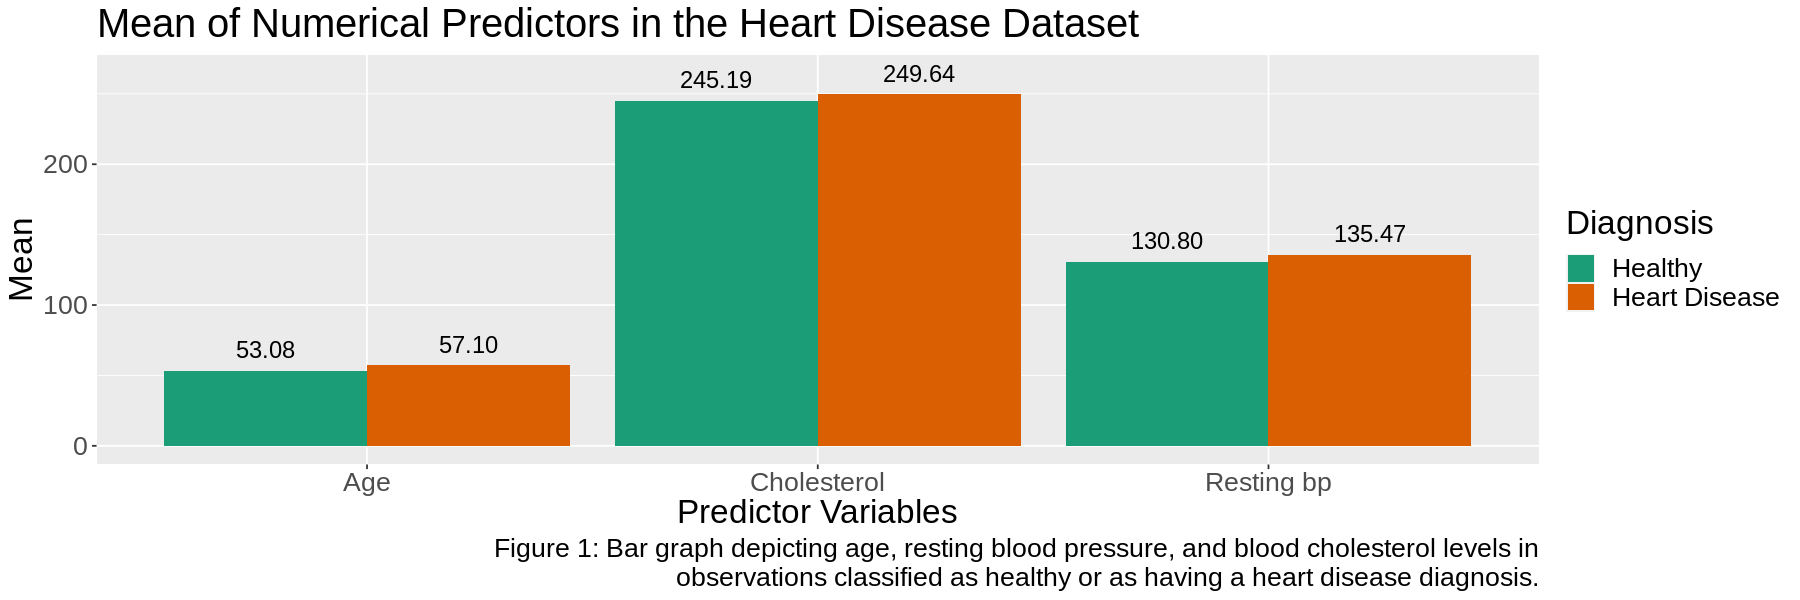

In [22]:
#plotting means of numerical predictors by diagnosis category
options(repr.plot.width = 15, repr.plot.height = 5)

predictor_numerical_plot <- numerical_predictors %>% 
    ggplot(aes(x = variable, y=mean, fill= factor(diagnosis,labels = c("Healthy", "Heart Disease")))) +
    geom_bar(alpha = 1, stat ="identity", position = "dodge") +
    annotate("text", label = "53.08", x = 0.775, y = 68.08, size = 5) +
    annotate("text", label = "57.10", x = 1.225, y = 72.10, size = 5) +
    annotate("text", label = "245.19", x = 1.775, y = 260.19, size = 5) +
    annotate("text", label = "249.64", x = 2.225, y = 264.63, size = 5) +
    annotate("text", label = "130.80", x = 2.775, y = 145.80, size = 5) +
    annotate("text", label = "135.47", x = 3.225, y = 150.47, size = 5) +
    scale_x_discrete(labels = c("Age", "Cholesterol", "Resting bp")) +
    labs(x = "Predictor Variables", y = "Mean", fill = "Diagnosis", title = "Mean of Numerical Predictors in the Heart Disease Dataset",
        caption = "Figure 1: Bar graph depicting age, resting blood pressure, and blood cholesterol levels in\nobservations classified as healthy or as having a heart disease diagnosis.") +
    scale_fill_brewer(palette = "Dark2") +
    theme(text = element_text(size=20))
predictor_numerical_plot

This plot displays the relationship between the mean of the numerical predictors and the class (diagnosis) using a bar graph.

Next, The factor variables are selected and bar plots showing proportions of these variables are created to visualize the relationship between the predictor values and diagnosis label. 

In [29]:
#selecting for factor variables and gathering values of each variable 
factor_predictors<- cleveland_train %>%
    select(-age, -resting_bp, -cholesterol) %>%
    gather("variable", "value", sex, cp_type, ECG_results, exercise_ang) %>%
    group_by(diagnosis, variable) 
   
factor_predictors

diagnosis,variable,value
<fct>,<chr>,<dbl>
0,sex,1
1,sex,1
0,sex,0
⋮,⋮,⋮
1,exercise_ang,1
1,exercise_ang,0
0,exercise_ang,0


Table 7: Used for the visualization of factor variables; each factor predictor variable is grouped by diagnostic label and variable value (0 or 1).

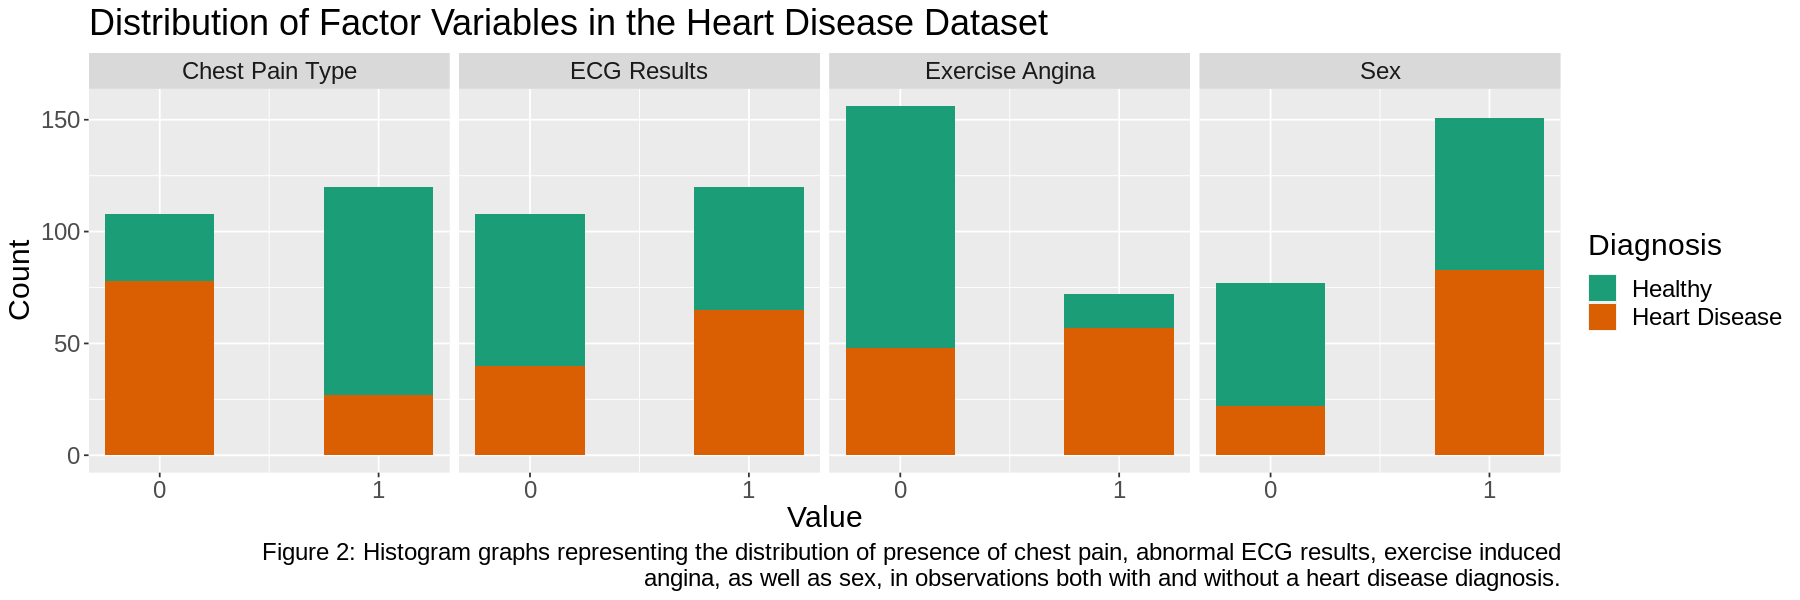

In [42]:
# Create a plot of the distributions of the factor predictors.
facet_titles <- c(`cp_type` = "Chest Pain Type",
                  `ECG_results` = "ECG Results",
                  `exercise_ang` = "Exercise Angina",
                  `sex` = "Sex")
options(repr.plot.width = 15, repr.plot.height = 5)

predictor_factor_plot <- ggplot(factor_predictors, aes(value, fill = factor(diagnosis, labels = c("Healthy", "Heart Disease")))) +
      geom_histogram(binwidth = 0.5) +
      facet_wrap(~c(variable), nrow = 1, labeller = as_labeller(facet_titles)) +
      ggtitle("Distribution of Factor Variables in the Heart Disease Dataset") +
      labs(x = "Value", y = "Count", fill ="Diagnosis",
          caption = "Figure 2: Histogram graphs representing the distribution of presence of chest pain, abnormal ECG results, exercise induced\nangina, as well as sex, in observations both with and without a heart disease diagnosis.") +
      scale_fill_brewer(palette = "Dark2") +
      scale_x_continuous(breaks = seq(0, 1, by = 1)) +
      theme(text = element_text(size=18))
predictor_factor_plot

**<p style = "font-size:18pt; font-style:bold"> Data Analysis </p>**

First of all, the training data is standardized and centered. This is done to make sure the data is consistent and to ensure each variable has the same scale, so that larger scales do not have more of an impact on KNN assignment. This will give all variables an average of 0 and a standard deviation of 1. This also ensures that different variables may be compared if needed. 

In [10]:
#Build recipe with predictor and outcome varibles, standardize training data 

cleveland_recipe <- recipe(diagnosis~ ., data=cleveland_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 
cleveland_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          7

Operations:

Scaling for all_predictors()
Centering for all_predictors()

A model specification is created. here, it is indicated that all data points will be weighed equally, the computational engine is kknn, and that we will be building a classification model. Additionally, instead of specifying a given parameter, we are tuning the model with many K values to determine which K value will give the model the highest accuracy. 

In [11]:
#create a model specification
knn_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) %>%
    set_engine ("kknn") %>%
    set_mode ("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Here, 5-fold cross validation is performed. Different K values are being evaluated using exclusively the training data. 

In [12]:
#perform 5-fold cross validaion 
cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = diagnosis)

Cross validation is run on each validation split within the training data. A workflow analysis is created to combine the new knn_tune model specification with the recipe. The tune_grid() function was used to fit the model for every paramater value. The collect_metrics() function aggregrates the standard error and the mean.

In [13]:
#train model with the training data set and run cross validation on each validation split
gridvals = tibble(neighbors = seq(1,15))

cleveland_results <- workflow() %>%
    add_recipe(cleveland_recipe) %>%
    add_model(knn_tune)%>%
    tune_grid(resamples = cleveland_vfold, grid = gridvals) %>%
    collect_metrics()

cleveland_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6974879,5,0.01948388,Model01
1,roc_auc,binary,0.6976190,5,0.01911639,Model01
2,accuracy,binary,0.6974879,5,0.01948388,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.8223889,5,0.02200085,Model14
15,accuracy,binary,0.7413527,5,0.02183639,Model15
15,roc_auc,binary,0.8329127,5,0.02120818,Model15


Table 8: Output table depicting the overall accuracy and ROC accuracy of each parameter value (in the mean column).

Here, we determine the best value for K by plotting accuracy by K-value. A line graph is used to visualize the accuracy of different K-values in predicting a diagnosis. Just by looking a the plot, we can see that K = 9 and K = 10 have the highest accuracies. 

In [32]:
#select parameter with greatest accuracy 

accuracies <- cleveland_results %>%
    filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6974879,5,0.01948388,Model01
2,accuracy,binary,0.6974879,5,0.01948388,Model02
3,accuracy,binary,0.7325604,5,0.02495982,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.7544928,5,0.01700277,Model13
14,accuracy,binary,0.7544928,5,0.01700277,Model14
15,accuracy,binary,0.7413527,5,0.02183639,Model15


Table 8.1: Output table containing only the overall accuracy of each tuned parameter value.

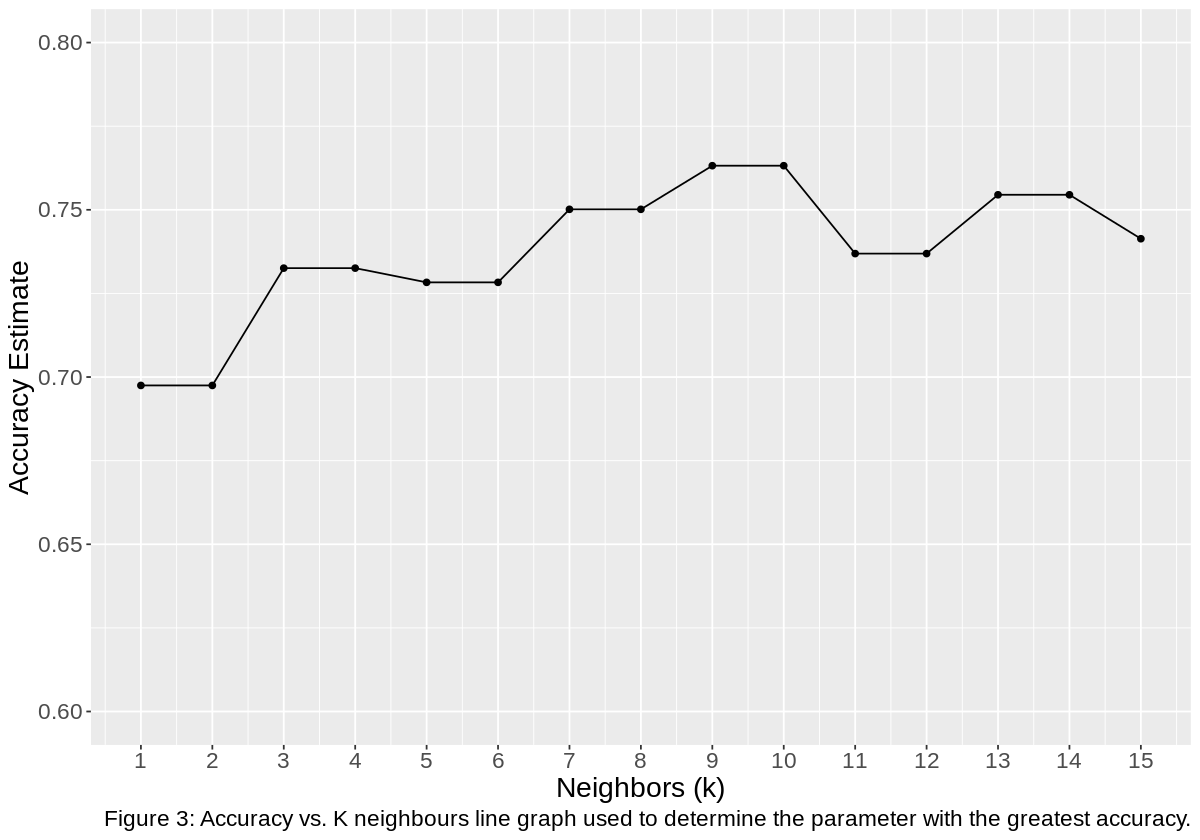

In [33]:
options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_plot <- accuracies %>%
    ggplot(aes (x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs (x = "Neighbors (k)", y = "Accuracy Estimate",
         caption = "Figure 3: Accuracy vs. K neighbours line graph used to determine the parameter with the greatest accuracy.") +
    theme(text = element_text(size=17)) +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) + 
    scale_y_continuous(limits = c(0.6, 0.8)) 
accuracy_plot

Visually, we know that K = 9 and K = 10 give the highest accuracies, but it is necessary to check if one gives a higher accuracy than the other. Here, the mean and K-values are selected and arranged in descending order. Now, we can see that indeed K = 9 and K = 10 both give the same accuracy. However, we can only choose one value for K. We are going to use K = 9 to avoid overfitting the model.

In [15]:
#selecting best parameter value 
knn_best <- accuracies %>% 
    select(mean, neighbors) %>%
    arrange(desc(mean))
head(knn_best)

mean,neighbors
<dbl>,<int>
0.7631884,9
0.7631884,10
0.7544928,13
0.7544928,14
0.7501449,7
0.7501449,8


Table 9: First 6 rows of a table containing the mean accuracy of the best K values.

Another model specification is built, but this time we specify that K = 9 must be used in the model. The training data is then fit to the new model specification. 

In [16]:
#build model specification with best value for K and fit training data with new model specification

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
    set_engine("kknn") %>%
    set_mode("classification")

cleveland_fit <- workflow() %>%
    add_recipe(cleveland_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = cleveland_train)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~9, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2719298
Best kernel: rectangular
Best k: 9

Finally, it is time to use the finished model to make predictions on new observations, that is, the testing set. Our model has an accuracy of approximately 81%  when predicting unknown diagnoses.

In [34]:
#Make predictions using testing data set 
cleveland_predictions <- predict(cleveland_fit, cleveland_test) %>%
    bind_cols(cleveland_test)
cleveland_predictions

.pred_class,age,sex,cp_type,resting_bp,cholesterol,ECG_results,exercise_ang,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,67,1,0,120,229,1,1,1
0,37,1,1,130,250,0,0,0
1,53,1,0,140,203,1,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,35,1,1,122,192,0,0,0
1,63,1,0,140,187,1,1,1
1,68,1,0,144,193,0,0,1


Table 10: Table containing the predicted diagnostic class of each observation in the testing dataset.

In [35]:
cleveland_metrics <- cleveland_predictions %>%
    metrics(truth = diagnosis, estimate = .pred_class)
cleveland_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8133333
kap,binary,0.6252677


Table 10.1: Table containing the prediction accuracy of our model when predicting labels of unknown testing data observations.

In [36]:
cleveland_conf_mat <- cleveland_predictions %>%
    conf_mat(truth = diagnosis, estimate = .pred_class)
cleveland_conf_mat

          Truth
Prediction  0  1
         0 33  6
         1  8 28

Table 10.2: Confusion matrix showing proportions of correct and incorrect (false positive and false negative) predictions on test data values.

Using the testing data predictions, a confusion matrix plot is created. This plot shows the performance of our classification model. Out of 75 predictions made on the testing set, 61 of those predictions were correct, with 8 false positives and 6 false negatives. 

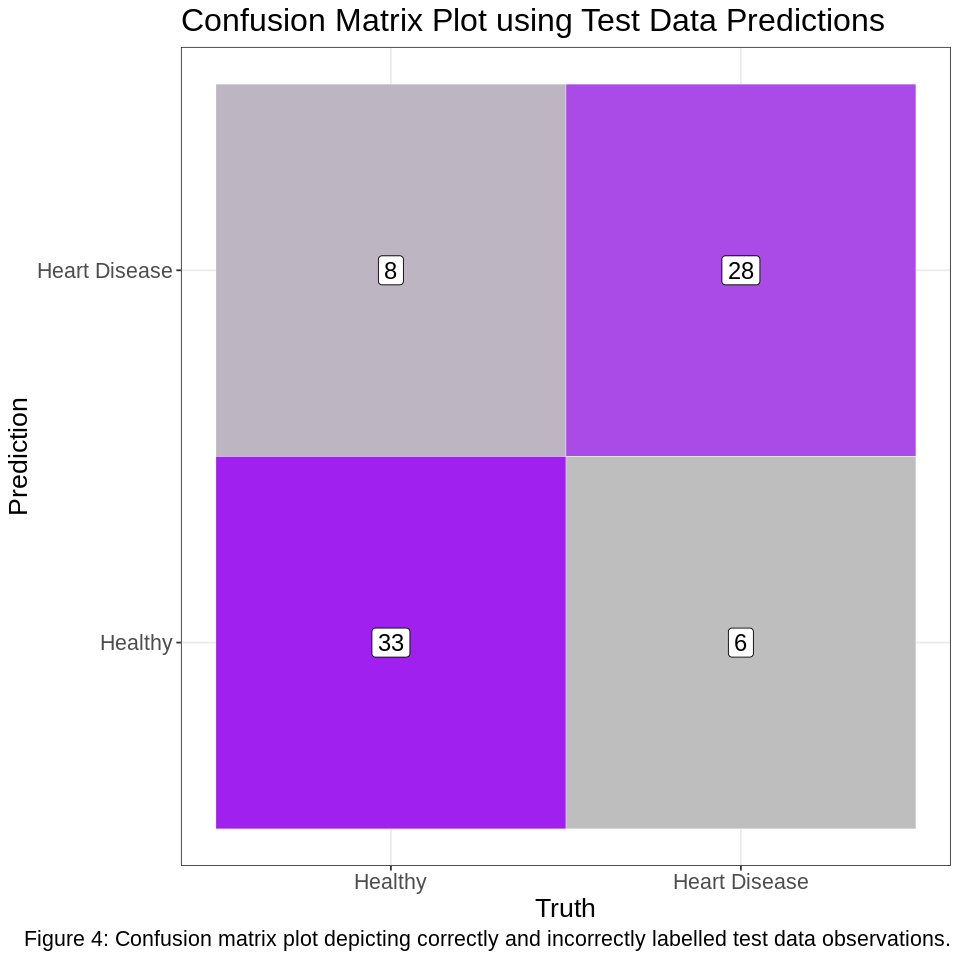

In [38]:
Truth <- factor(c(1, 1, 0, 0))
Prediction <- factor(c(0, 1, 0, 1))
Y <- c(6, 28, 33, 8)
df<- data.frame(Truth, Prediction, Y)

options(repr.plot.width = 8, repr.plot.height = 8)
cleveland_matrix_plot <- ggplot(data = df, mapping = aes(x = Truth, y = Prediction)) +
    geom_tile(aes(fill = Y), colour = "white") +
    geom_label(aes(label=Y), size = 5) +
    scale_fill_gradient(low = "grey", high = "purple") +
    scale_x_discrete(labels = c("1" = "Heart Disease", "0" = "Healthy")) +
    scale_y_discrete(labels = c("1" = "Heart Disease", "0" = "Healthy")) +
    theme_bw() + theme(legend.position="none") +
    labs(x = "Truth", y = "Prediction", title="Confusion Matrix Plot using Test Data Predictions",
        caption = "Figure 4: Confusion matrix plot depicting correctly and incorrectly labelled test data observations.") +
    theme(text = element_text(size=16)) 
    
cleveland_matrix_plot

**<p style = "font-size:18pt; font-style:bold"> Discussion </p>**

Our final classification model was able to accurately predict the presence of heart disease in a new patient with roughly a 81% accuracy. The model uses related predictors, such as age, sex, resting blood pressure and cholesterol levels, to determine if a patient has heart disease. This classification model can help aid the beginning stages of the diagnosis process. By being able to predict the presence of heart disease based on related predictors the classification model can help identify patients with heart disease with less rigourous and potentially expensive testing. This will be beneficial to aid in ease of diagnosis for patients with heart disease, which could potentially help diagnose more people early on in the progression. Through the use of the classification model, some questions may arise such as, which predictors relate the most to the presence of heart disease? And is there one predictor that is stronger than others in accurately predicting the presence of heart disease?

**<p style = "font-size:18pt; font-style:bold"> References </p>**

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., and Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *The Americal Journal of Cardiology,* 64, 304–310. https://doi.org/10.1016/0002-9149(89)90524-9 

Maas, A. H. E. M. & Appelman, Y. E. A. (2011). Gender differences in coronary heart disease. *Netherlands Heart Journal,* 18, 589 - 602. https://doi.org/10.1007/s12471-010-0841-y

Robson, J., Ayerbe, L., Mathur, R., Addo, J., & Wragg, A. (2015). Clinical value of chest pain presentation and prodromes on the assessment of cardiovascular disease: a cohort study. *BJM Open,* 5, 1-6. https://doi.org/10.1136/bmjopen-2014-007251

Whincup, P. H., Wannamethee, G., Macfarlane, P. W., Walker, M. & Shaper, G. A. (1995). Resting electrocardiogram and risk of coronary heart disease in middle-ages British men. *Journal of Cardiovascular Risk,* 2, 533-543. https://doi.org/10.1177/174182679500200608


World Health Organization. (2021). *Cardiovascular Diseases (CVDs)*. Retreived from https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)


Yusuf, S., Reddy, S., Ounpuu, S. & Anand, S. (2001) Global Burden of Cardiovascular Diseases: Part I: General Considerations, the Epidemiologic Transition, Risk Factors, and Impact of Urbanization. *Circulation,* 104, 2746-2753. https://doi.org/10.1161/hc4601.099487
